In [167]:
import kagglehub
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 

## Step 1: Download the Heart Failure Prediction Dataset


In [168]:
# Load the dataset
# dataset = pd.read_csv("C:\\Users\\antoi\\.cache\\kagglehub\\datasets\\fedesoriano\\heart-failure-prediction\\versions\\1\\heart.csv")
# dataset.head() 

import os
import zipfile
# Download the dataset
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

# Check if the dataset is a ZIP file
if path.endswith('.zip'):
    # Extract the ZIP file
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall("extracted_dataset")
    
    # Find the CSV file in the extracted folder
    extracted_folder = "extracted_dataset"
    csv_file = [f for f in os.listdir(extracted_folder) if f.endswith('.csv')][0]
    csv_file_path = os.path.join(extracted_folder, csv_file)
else:
    # If it's not a ZIP file, look for the CSV file directly
    csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
    csv_file_path = os.path.join(path, csv_file)

# Load the dataset with pandas
dataset = pd.read_csv(csv_file_path)

# Display the dataset
dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Step 2: Dataset Preparation

In [169]:
#Setting a random seed ensures that any random processes produce the same results each time the code is run.
import random
random.seed(42)

### Feature Preprocessing

In [170]:
X = dataset.drop(columns="HeartDisease")  # All columns except the target --> feature matrix
y = dataset["HeartDisease"]               # Target column --> target vector

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()   # scale features between 0 and 1 -> (x - min) / (max - min)
# scalar = StandardScaler() # scale features to have mean=0 and variance=1 -> (x - mean) / std

# Normalize only numeric columns
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = scaler.fit_transform(X[[col]])
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.244898,M,ATA,0.70,0.479270,0.0,Normal,0.788732,N,0.295455,Up
1,0.428571,F,NAP,0.80,0.298507,0.0,Normal,0.676056,N,0.409091,Flat
2,0.183673,M,ATA,0.65,0.469320,0.0,ST,0.267606,N,0.295455,Up
3,0.408163,F,ASY,0.69,0.354892,0.0,Normal,0.338028,Y,0.465909,Flat
4,0.530612,M,NAP,0.75,0.323383,0.0,Normal,0.436620,N,0.295455,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,0.346939,M,TA,0.55,0.437811,0.0,Normal,0.507042,N,0.431818,Flat
914,0.816327,M,ASY,0.72,0.320066,1.0,Normal,0.570423,N,0.681818,Flat
915,0.591837,M,ASY,0.65,0.217247,0.0,Normal,0.387324,Y,0.431818,Flat
916,0.591837,F,ATA,0.65,0.391376,0.0,LVH,0.802817,N,0.295455,Flat


In [171]:
# Categorical features one-hot encoding
cat_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print(X.head())

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Sex_M  \
0  0.244898       0.70     0.479270        0.0  0.788732  0.295455      1   
1  0.428571       0.80     0.298507        0.0  0.676056  0.409091      0   
2  0.183673       0.65     0.469320        0.0  0.267606  0.295455      1   
3  0.408163       0.69     0.354892        0.0  0.338028  0.465909      0   
4  0.530612       0.75     0.323383        0.0  0.436620  0.295455      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  \
0                  1                  0                 0                  1   
1                  0                  1                 0                  1   
2                  1                  0                 0                  0   
3                  0                  0                 0                  1   
4                  0                  1                 0                  1   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Sl

### Train/Validation/Test Split

In [172]:
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, 
    random_state=42,   # For reproducibility ------> no need for shuffling
    test_size=0.3,     # 30% for testing and validation, 70% for training
    stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, 
    random_state=42,   # For reproducibility ------> no need for shuffling
    test_size=1/3,     # 20% for testing, 10% for validation of the whole dataset
    stratify=y_test_val
)

# Ensuring Ratio between number of zeros and ones are the same for all sets
print("Test Set: ")
print(y_test.value_counts())
print("Ratio = ", y_test.value_counts()[0]/y_test.value_counts()[1])
print("---------------------------------------")
print("Validation Set: ")
print(y_val.value_counts())
print("Ratio = ", y_val.value_counts()[0]/y_val.value_counts()[1])
print("---------------------------------------")
print("Training Set: ")
print(y_train.value_counts())
print("Ratio = ", y_train.value_counts()[0]/y_train.value_counts()[1])
print("---------------------------------------")

print(len(X_train), len(X_test), len(X_val))
print(len(X), len(y))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

Test Set: 
1    102
0     82
Name: HeartDisease, dtype: int64
Ratio =  0.803921568627451
---------------------------------------
Validation Set: 
1    51
0    41
Name: HeartDisease, dtype: int64
Ratio =  0.803921568627451
---------------------------------------
Training Set: 
1    355
0    287
Name: HeartDisease, dtype: int64
Ratio =  0.8084507042253521
---------------------------------------
642 184 92
918 918
X_train shape: (642, 15)
X_val shape: (92, 15)


## Step 3: Implementation

Working with a range of classification algorithms from scratch:
1. Decision Tree
2. Bagging Ensemble
3. AdaBoost Ensemble

## Step 3.1: Decision Tree 

In [173]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Index of the feature to split on
        self.threshold = threshold  # Threshold value for splitting
        self.left = left # Left child node
        self.right = right # Right child node
        self.value = value  # Value aw el Class label if the node is a leaf node
        

In [174]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None    # Root node
    
    # Calculate the entropy of a list of labels
    def entropy(self, y):
        label_count = np.bincount(y)  
        probabilities = label_count / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    # Calculate the information gain of a split
    def information_gain(self, X_feature_column, y, threshold):
        parent_entropy = self.entropy(y)
        
        # Split the data
        left_indices = X_feature_column < threshold
        right_indices = X_feature_column >= threshold
        
        # Ignore the split if it doesn't divide the data
        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0
        
        # Calculate the weighted avg entropy of the children
        n, left_n, right_n = len(y), len(y[left_indices]), len(y[right_indices])
        # n, left_n, right_n = len(y), sum(left_indices), sum(right_indices)
        left_entropy = self.entropy(y[left_indices])
        right_entropy = self.entropy(y[right_indices])
        weighted_avg_child_entropy = (left_n / n) * left_entropy + (right_n / n) * right_entropy
        
        # Calculate the information gain
        return parent_entropy - weighted_avg_child_entropy
    
    # Find the best feature and threshold to split on
    def best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])   #try all unique values in the feature as thresholds
            for threshold in thresholds:
                gain = self.information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    # Build the decision tree recursively
    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))        # num of classes
        
        # Stopping conditions
        if depth >= self.max_depth or n_samples < self.min_samples_split or n_labels == 1:
            leaf_value = np.argmax(np.bincount(y))      #majority class label
            return Node(value=leaf_value)
        
        # Find the best split
        best_feature, best_threshold = self.best_split(X, y)
        
        if best_feature is None or best_threshold is None:
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value) 
            # return Node(value=np.argmax(np.bincount(y)))
        
        # Split the data
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        
        left_child = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self.build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(best_feature, best_threshold, left_child, right_child)
    
    # Train the decision tree
    def fit(self, X, y):
        # Convert Pandas DataFrame and Series to NumPy arrays if necessary
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
    
        self.root = self.build_tree(X, y)
    
    # Predict the class of a single sample
    def predict(self, x_sample, node=None):
        if node is None:
            node = self.root
        
        if node.value is not None:
            return node.value
        
        if x_sample[node.feature] < node.threshold:
            return self.predict(x_sample, node.left)
        else:
            return self.predict(x_sample, node.right)
        
    # Predict the classes of multiple samples
    def predict_all(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()  # Ensure X is a NumPy array
        return np.array([self.predict(x_sample, self.root) for x_sample in X])

In [175]:
# Train the decision tree
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix

# dict_decision_tree = {}
results_decision_tree = {}
val_f1_score_list = []  # Initialize the list to store the results
train_f1_score_list = []

for depth in range(2, 16, 1):
    train_accuracy_decision_tree, val_accuracy_decision_tree = [], []
    train_f1_score_decision_tree, val_f1_score_decision_tree = [], []
    
    for min_samples in range(2, 11, 2):
        y_pred_train = None
        y_pred_val = None
        tree = DecisionTree(max_depth=depth, min_samples_split=min_samples)
        tree.fit(X_train.values, y_train.values)
        
        # Predict the classes of the test set
        y_pred_train = tree.predict_all(X_train.values)
        train_accuracy = round(accuracy_score(y_train, y_pred_train) * 100, 3)
        f1_score_train = round(f1_score(y_train, y_pred_train, average='macro') * 100, 3)
        train_f1_score_decision_tree.append(f1_score_train)
        train_accuracy_decision_tree.append(train_accuracy)
        
        # Predict the classes of the validation set
        y_pred_val = tree.predict_all(X_val.values)
        val_accuracy = round(accuracy_score(y_val, y_pred_val) * 100, 3)
        f1_score_val = round(f1_score(y_val, y_pred_val, average='macro') * 100, 3)
        val_f1_score_decision_tree.append(f1_score_val)
        val_accuracy_decision_tree.append(val_accuracy)
        
        # Append the results to the list
        val_f1_score_list.append({'Depth': depth, 'Min Samples': min_samples, 'Validation F1 Score': f1_score_val})
        train_f1_score_list.append({'Depth': depth, 'Min Samples': min_samples, 'Train F1 Score': f1_score_train})
    
    results_decision_tree[depth] = {
        "train_accuracy": train_accuracy_decision_tree,
        "val_accuracy": val_accuracy_decision_tree,
        "train_f1_score": train_f1_score_decision_tree,
        "val_f1_score": val_f1_score_decision_tree,
    }


# Create a DataFrame from the list
val_f1_score_df = pd.DataFrame(val_f1_score_list)

# Pivot the DataFrame to represent depth as columns and min_samples as rows
val_f1_score_pivot = val_f1_score_df.pivot(index='Min Samples', columns='Depth', values='Validation F1 Score')
val_f1_score_pivot = val_f1_score_pivot.applymap(lambda x: f"{x}%")

train_f1_score_df = pd.DataFrame(train_f1_score_list)
train_f1_score_pivot = train_f1_score_df.pivot(index='Min Samples', columns='Depth', values='Train F1 Score')
train_f1_score_pivot = train_f1_score_pivot.applymap(lambda x: f"{x}%")





In [176]:
train_f1_score_pivot

Depth,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Min Samples,,,,,,,,,,,,,,
2,82.971%,84.867%,87.074%,88.526%,91.745%,93.37%,95.577%,98.268%,99.055%,100.0%,100.0%,100.0%,100.0%,100.0%
4,82.971%,84.867%,87.074%,88.526%,91.745%,93.21%,95.105%,97.639%,98.111%,98.74%,98.74%,98.74%,98.74%,98.74%
6,82.971%,84.867%,87.074%,88.526%,91.435%,92.899%,94.481%,96.229%,96.699%,96.699%,96.699%,96.699%,96.699%,96.699%
8,82.971%,84.867%,87.074%,88.365%,91.125%,92.423%,93.059%,94.813%,95.127%,95.127%,95.127%,95.127%,95.127%,95.127%
10,82.971%,84.867%,87.074%,88.365%,91.125%,92.423%,92.888%,94.022%,94.029%,94.029%,94.029%,94.029%,94.029%,94.029%


In [177]:
val_f1_score_pivot

Depth,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Min Samples,,,,,,,,,,,,,,
2,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,83.601%,84.718%,84.718%,84.718%,84.718%,84.718%
4,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,83.601%,84.718%,84.718%,84.718%,84.718%,84.718%
6,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,83.601%,83.601%,83.601%,83.601%,83.601%,83.601%
8,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,82.534%,83.647%,82.534%,82.534%,82.534%,82.534%,82.534%,82.534%
10,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,84.718%,84.718%,84.718%,84.718%,84.718%,84.718%


In [178]:
print("Train Accuracy: ",results_decision_tree[5]['train_accuracy'][0], '%')
print("Train F1 Score: ", results_decision_tree[5]['train_f1_score'][0], '%')
print("Validation Accuracy: ", results_decision_tree[5]['val_accuracy'][0], '%')
print("Validation F1 Score: ", results_decision_tree[5]['val_f1_score'][0], '%')

Train Accuracy:  88.629 %
Train F1 Score:  88.526 %
Validation Accuracy:  84.783 %
Validation F1 Score:  84.718 %


Best Hyperparameters: Depth = 5 and Min Samples = 2
Best Validation Accuracy: 84.7830%
Validation F1 Score: 84.7176%


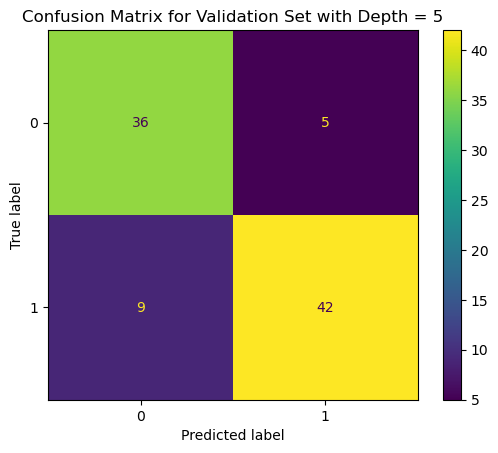

Training Set Results, For Depth =  5  and Min Samples =  2
Train Accuracy =  88.629 %
Train F1 Score =  88.526 %


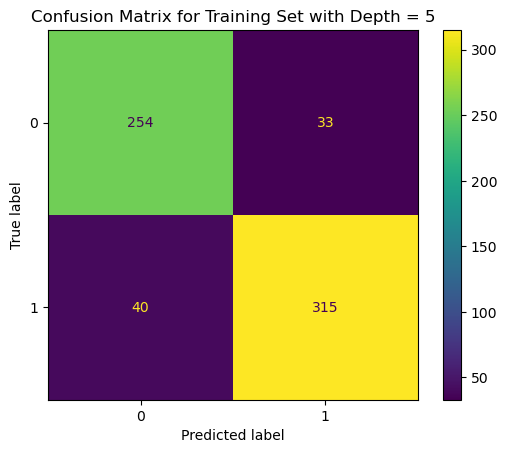

In [179]:
# Find the best hyperparameters

best_depth = None
best_min_samples = None
best_val_accuracy = 0

for depth, metrics in results_decision_tree.items():
    for i, val_acc in enumerate(metrics["val_accuracy"]):
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_depth = depth
            best_min_samples = i + 2  # since min_samples starts from 2

print(f"Best Hyperparameters: Depth = {best_depth} and Min Samples = {best_min_samples}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}%")

# Train the decision tree with the best hyperparameters
tree = DecisionTree(max_depth=best_depth, min_samples_split=5)
tree.fit(X_train.values, y_train.values)

# Predict the classes of the validation set
# y_val_pred = tree.predict_all(X_val.values)

# Calculate the F1 score for the validation set
f1_score_val = f1_score(y_val, y_pred_val, average='macro')
print(f"Validation F1 Score: {f1_score_val * 100:.4f}%")

# Display the confusion matrix for the validation set
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Validation Set with Depth = {best_depth}")
plt.show()

print("Training Set Results, For Depth = ", best_depth, " and Min Samples = ", best_min_samples)
print("Train Accuracy = ", results_decision_tree[best_depth]['train_accuracy'][best_min_samples-2], "%")
print("Train F1 Score = ", results_decision_tree[best_depth]['train_f1_score'][best_min_samples-2], "%")

# Display the confusion matrix for the training set with the best hyperparameters
y_train_pred = tree.predict_all(X_train.values)
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=list(range(2)))
disp_train.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Training Set with Depth = {best_depth}")
plt.show()



Test Accuracy: 85.3261%
Test F1 Score: 85.3169%


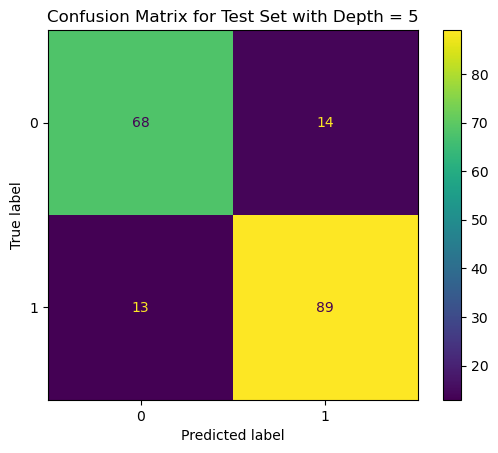

In [180]:
# Train the final model with the best hyperparameters
test_tree = DecisionTree(max_depth=best_depth, min_samples_split=best_min_samples)
test_tree.fit(X_train.values, y_train.values)

# Predict the classes of the test set with the best hyperparameters
y_test_pred = test_tree.predict_all(X_test.values)

# Computr test accuracy and F1 score on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test F1 Score: {test_f1_score * 100:.4f}%")

# Display the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Test Set with Depth = {best_depth}")
plt.show()

## Step 3.2: Bagging Ensemble

Number of datasets = 10, Training Accuracy = 0.897196261682243
Number of datasets = 10, Validation Accuracy = 0.8478260869565217


Number of datasets = 15, Training Accuracy = 0.8987538940809969
Number of datasets = 15, Validation Accuracy = 0.8695652173913043


Number of datasets = 20, Training Accuracy = 0.897196261682243
Number of datasets = 20, Validation Accuracy = 0.8478260869565217


Number of datasets = 25, Training Accuracy = 0.9158878504672897
Number of datasets = 25, Validation Accuracy = 0.8695652173913043


Number of datasets = 30, Training Accuracy = 0.8987538940809969
Number of datasets = 30, Validation Accuracy = 0.8369565217391305


Number of datasets = 35, Training Accuracy = 0.9112149532710281
Number of datasets = 35, Validation Accuracy = 0.8478260869565217



Best n estimators: 15 with Validation Accuracy: 0.8695652173913043

Test accuracy with best n estimators 15 =  0.8858695652173914

Confusion Matrix for Training Set with Bagging Ensemble with best n_estimators

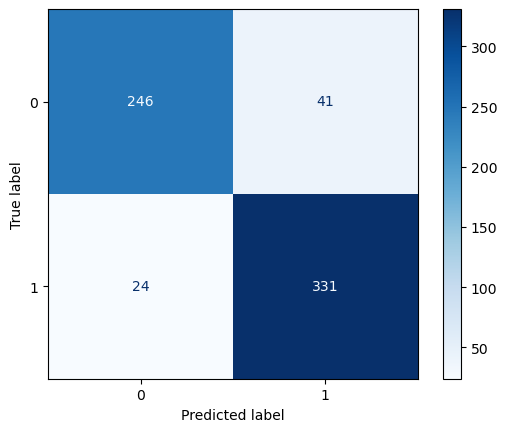

Confusion Matrix for Validation Set with Bagging Ensemble with best n_estimators =  15
Accuracy:  0.8695652173913043
F1 Score:  0.8775510204081632


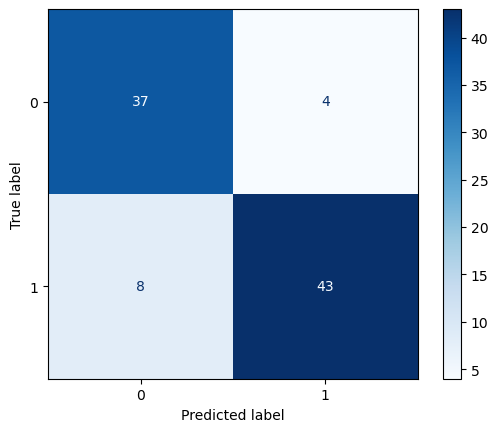

Confusion Matrix for Test Set with Bagging Ensemble with best n_estimators =  15
Accuracy:  0.8858695652173914
F1 Score:  0.8995215311004785


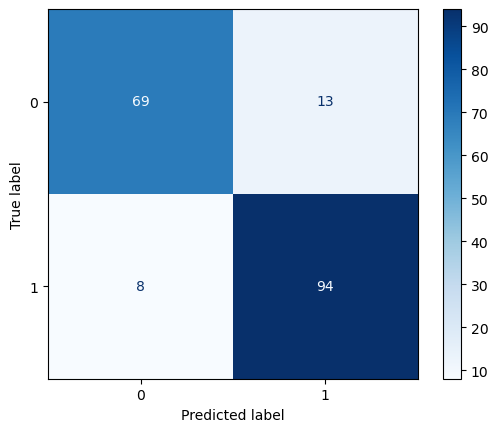

In [181]:
from sklearn.metrics import accuracy_score
from sklearn.utils import resample


class BaggingEnsemble:
 
    #Create bootstrap samples randomly
    def create_samples(self, X, y, num_of_resamples):
        bootstrap_samples = []
        for i in range(num_of_resamples):
            resampled_X, resampled_y = resample(X, y, replace = True) 
            bootstrap_samples.append((resampled_X, resampled_y))
        
        return bootstrap_samples
    
    #obtain decision tree for each bootstrap
    def train_models(self, bootstrap_samples):
        base_learners = []
        for resampled_X, resampled_y in bootstrap_samples:
            decision_tree = DecisionTree(max_depth=5, min_samples_split=2)  # Using custom DecisionTree
            decision_tree.fit(resampled_X, resampled_y)
            base_learners.append(decision_tree)
            
        return base_learners
    
    # Calculate majority vote for predictions
    def majority_predictions(self, base_learners, X):
        # Each col represents the predictions of a certain sample and each row represents a certain decision tree from base_learners
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy() # Convert Pandas DataFrame to NumPy array if necessary
        all_predictions = np.array([tree.predict_all(X) for tree in base_learners]) 
        final_prediction = np.apply_along_axis(lambda y: np.bincount(y).argmax(), axis=0, arr=all_predictions)
         
        return final_prediction
    
    
# Lists to store results
train_results = []
val_results = []

num_of_datasets = [10, 15, 20, 25, 30, 35]
highest_accuracy = 0
best_n_dataset = None
best_base_learners = []
bagging_ensemble = BaggingEnsemble()
# Evaluate accuracy for different hyperparameter n using validation set
for n in num_of_datasets:
        
    bootstrap_samples = bagging_ensemble.create_samples(X_train, y_train, n)
    base_learners = bagging_ensemble.train_models(bootstrap_samples)
    
    predicted_y_training = bagging_ensemble.majority_predictions(base_learners, X_train)
    training_accuracy = accuracy_score(y_train, predicted_y_training)
    print(f"Number of datasets = {n}, Training Accuracy = {training_accuracy}")
    
    predicted_y_val = bagging_ensemble.majority_predictions(base_learners, X_val)
    val_accuracy = accuracy_score(y_val, predicted_y_val)
    print(f"Number of datasets = {n}, Validation Accuracy = {val_accuracy}\n\n")
    
    # Store results in lists
    train_results.append({"Number of Datasets": n, "Training Accuracy": training_accuracy})
    val_results.append({"Number of Datasets": n, "Validation Accuracy": val_accuracy})
    
    if val_accuracy > highest_accuracy:
        highest_accuracy = val_accuracy
        best_n_dataset = n
        best_base_learners = base_learners
               

print(f"\nBest n estimators: {best_n_dataset} with Validation Accuracy: {highest_accuracy}")  

# Test the model
predicted_y_test = bagging_ensemble.majority_predictions(best_base_learners, X_test)
testing_accuracy = accuracy_score(y_test, predicted_y_test)
print(f"\nTest accuracy with best n estimators {best_n_dataset} =  {testing_accuracy}\n") 

# Plot confusion matrix and display accuracy and F1 score
print("Confusion Matrix for Training Set with Bagging Ensemble with best n_estimators = ", best_n_dataset)
predicted_y_train = bagging_ensemble.majority_predictions(best_base_learners, X_train)
print("Accuracy: ", accuracy_score(y_train, predicted_y_train))
f1_score_train = f1_score(y_train, predicted_y_train)
print("F1 Score: ", f1_score_train)
cm = confusion_matrix(y_train, predicted_y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='Blues', values_format='d')
plt.show()

print("Confusion Matrix for Validation Set with Bagging Ensemble with best n_estimators = ", best_n_dataset)
print("Accuracy: ", highest_accuracy)
predicted_y_validation = bagging_ensemble.majority_predictions(best_base_learners, X_val)
f1_score_validation = f1_score(y_val, predicted_y_validation)
print("F1 Score: ", f1_score_validation)
cm = confusion_matrix(y_val, predicted_y_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='Blues', values_format='d')
plt.show()

print("Confusion Matrix for Test Set with Bagging Ensemble with best n_estimators = ", best_n_dataset)
print("Accuracy: ", testing_accuracy)
f1_score_test = f1_score(y_test, predicted_y_test)
print("F1 Score: ", f1_score_test)
cm = confusion_matrix(y_test, predicted_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='Blues', values_format='d')
plt.show()

    

In [182]:
# Convert lists to DataFrames
train_df_accuracy = pd.DataFrame(train_results)
val_df_accuracy = pd.DataFrame(val_results)
print("Training Accuracy DataFrame:")
print(train_df_accuracy)

print("\nValidation Accuracy DataFrame:")
print(val_df_accuracy)

Training Accuracy DataFrame:
   Number of Datasets  Training Accuracy
0                  10           0.897196
1                  15           0.898754
2                  20           0.897196
3                  25           0.915888
4                  30           0.898754
5                  35           0.911215

Validation Accuracy DataFrame:
   Number of Datasets  Validation Accuracy
0                  10             0.847826
1                  15             0.869565
2                  20             0.847826
3                  25             0.869565
4                  30             0.836957
5                  35             0.847826


## Step 3.3: AdaBoost Ensemble

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

class AdaBoost:

    def __init__(self, X_train, X_test, X_val, y_train, y_test, y_val):
        # Initialize datasets
        self.X_train = X_train
        self.X_test = X_test
        self.X_val = X_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val

        # Initialize weights uniformly across all training samples
        self.weights = np.ones(len(y_train)) / len(y_train)

        # Store alpha values (model contributions) and weak learners
        self.alphaArr = []
        self.decision_trees = []

    def error(self, predicted, y):
        """ Calculate the weighted error (sum of weights for misclassified points). """
        return np.sum(self.weights * (predicted != y)) / np.sum(self.weights)

    def alpha(self, errorVal):
        """ Calculate the model's contribution (alpha) using the error. """
        # Clip error to avoid division by zero or taking log(0)
        errorVal = np.clip(errorVal, 1e-10, 1 - 1e-10)
        return 0.5 * np.log((1 - errorVal) / errorVal)

    def reweight(self, predicted, alphaVal):
        """ Update weights to focus on misclassified samples. """
        # Misclassified points get higher weights
        self.weights *= np.exp(-1 * alphaVal * np.where(predicted != self.y_train, -1, 1))

        # Normalize weights to sum to 1
        self.weights /= np.sum(self.weights)

    def _train_(self):
        """ Train a weak learner (decision stump) for one iteration. """
        # Create and fit a decision tree with max_depth=1 (stump)
        dtree = DecisionTreeClassifier(max_depth=1)
        dtree.fit(self.X_train, self.y_train, sample_weight=self.weights)

        # Predict on the training set
        prediction = dtree.predict(self.X_train)

        # Calculate weighted error
        err = self.error(prediction, self.y_train)

        # Only add weak learners with error < 0.5
        if err < 0.5:
            # Compute the model's contribution (alpha)
            alphaVal = self.alpha(err)

            # Store the model and its alpha value
            self.decision_trees.append(dtree)
            self.alphaArr.append(alphaVal)

            # Update sample weights
            self.reweight(prediction, alphaVal)

        return prediction, err

    def train(self):
        """ Train the AdaBoost ensemble model. """
        final_res = np.zeros(len(self.y_train))
        iteration_max = 100
        no_improve_limit = 5

        best_val_error = float('inf')
        no_improve_count = 0

        best_decision_trees = []
        best_alphaArr = []

        train_errors = []
        val_errors = []
        test_errors = []

        for i in range(iteration_max):

            # Train a weak learner
            prediction, err = self._train_()

            # Stop if error exceeds or equals 0.5
            if err >= 0.5:
                print(f"Stopping early at iteration {i} (error={err:.4f})")
                break

            # Calculate training error
            trainError = np.sum(prediction != self.y_train) / len(self.y_train)

            # Map predictions to {-1, 1} for AdaBoost math
            prediction = np.where(prediction == 0, -1, 1)
            final_res += self.alphaArr[i] * prediction

            train_errors.append(trainError)

            # Stop if perfect fit is achieved
            if err == 0:
                print(f"Perfect fit at iteration {i}.")
                break

            # Validate on validation set
            val = self.validate()
            val_errors.append(val)
            tes = self.test()
            test_errors.append(tes)

            # Check for validation improvement
            if val < best_val_error:
                best_val_error = val
                no_improve_count = 0
                best_decision_trees = self.decision_trees[:]
                best_alphaArr = self.alphaArr[:]
            else:
                no_improve_count += 1

            # If no improvement for `no_improve_limit` cycles, rollback and halt
            if no_improve_count >= no_improve_limit:
                print(f"No improvement for {no_improve_limit} cycles. Stopping at iteration {i}.")

                self.decision_trees = best_decision_trees
                self.alphaArr = best_alphaArr

                # Recompute final result
                final_res = np.zeros(len(self.y_train))
                for j in range(len(self.decision_trees)):
                    prediction = self.decision_trees[j].predict(self.X_train)
                    prediction = np.where(prediction == 0, -1, 1)
                    final_res += self.alphaArr[j] * prediction

                break

        # Plot training vs validation error
        plt.plot(range(len(train_errors)), train_errors, label='Training Error')
        plt.plot(range(len(val_errors)), val_errors, label='Validation Error')
        plt.plot(range(len(test_errors)), test_errors, label='test Error')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Training vs Validation Error')
        plt.legend()
        plt.show()

        return np.where(final_res > 0, 1, 0)
    
    def validateOrTest(self, x_test_val, y_test_val):
        """ Predict using the ensemble of weak learners. """
        final_res = np.zeros(len(y_test_val))

        for i in range(len(self.decision_trees)):
            prediction = self.decision_trees[i].predict(x_test_val)
            prediction = np.where(prediction == 0, -1, 1)
            final_res += self.alphaArr[i] * prediction

        return np.where(final_res > 0, 1, 0)

    def test(self):
        """ Evaluate the model on the test set. """
        prediction = self.validateOrTest(self.X_test, self.y_test)
        return np.sum(prediction != self.y_test) / len(self.y_test)

    def validate(self):
        """ Evaluate the model on the validation set. """
        prediction = self.validateOrTest(self.X_val, self.y_val)
        return np.sum(prediction != self.y_val) / len(self.y_val)

    def predict(self, x):
        """ Predict a single sample. """
        final_res = 0

        for i in range(len(self.decision_trees)):
            prediction = self.decision_trees[i].predict(x)
            prediction = np.where(prediction == 0, -1, 1)
            final_res += self.alphaArr[i] * prediction

        return 1 if final_res > 0 else 0

    def evaluate(self, x, y, dataset_name="Test"):
        """ Evaluate the model on a given dataset and display accuracy, F1-score, and confusion matrix. """
        # Get predictions
        predictions = self.validateOrTest(x, y)

        # Calculate metrics
        acc = accuracy_score(y, predictions)
        f1 = f1_score(y, predictions)
        cm = confusion_matrix(y, predictions)

        print(f"{dataset_name} Set Evaluation:")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-Score: {f1:.4f}\n")

        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{dataset_name} Set Confusion Matrix")
        plt.show()

    def full_evaluation(self):
        """ Evaluate the model on training, validation, and test sets. """
        self.evaluate(self.X_train, self.y_train, "Training")
        self.evaluate(self.X_val, self.y_val, "Validation")
        self.evaluate(self.X_test, self.y_test, "Test")


No improvement for 5 cycles. Stopping at iteration 11.


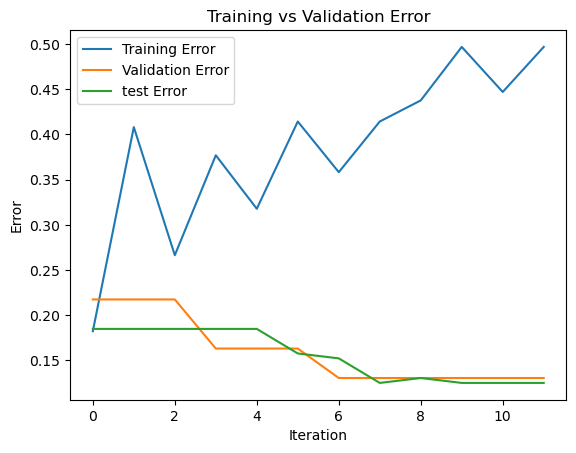

Training Set Evaluation:
Accuracy: 0.8427
F1-Score: 0.8579



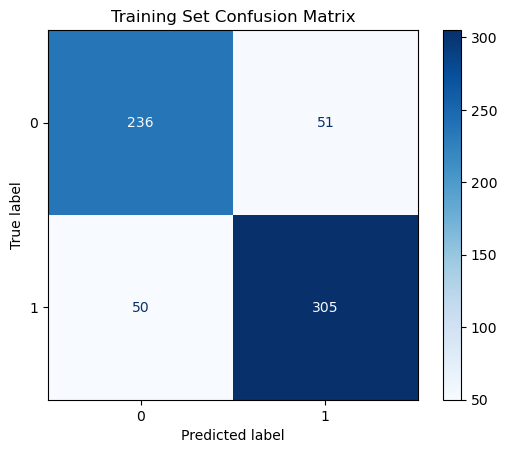

Validation Set Evaluation:
Accuracy: 0.8696
F1-Score: 0.8776



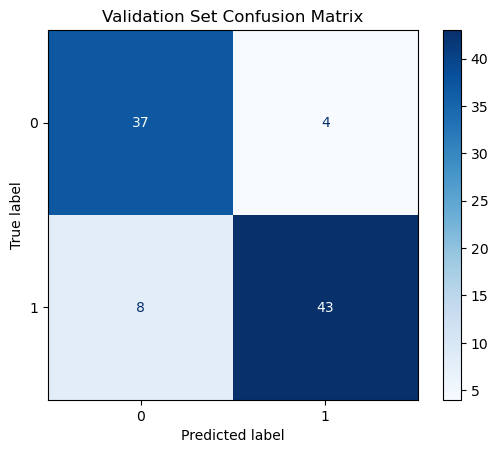

Test Set Evaluation:
Accuracy: 0.8478
F1-Score: 0.8641



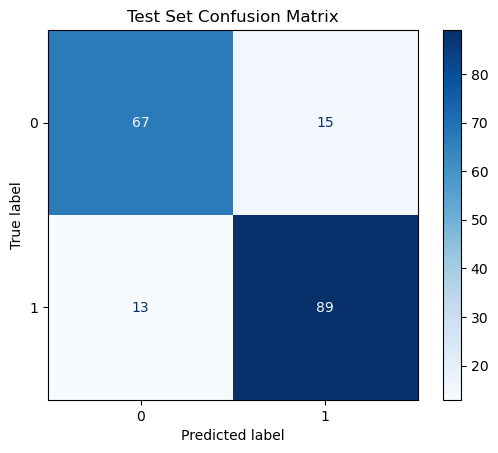

'done'

In [184]:
model = AdaBoost(X_train, X_test, X_val, y_train, y_test, y_val )
tr =model.train()
t =model.test()
v = model.validate()
model.full_evaluation()



"""to be done"""
"""done"""
# need to put a fixed threshold on the diff between the tr error and val error  to detect overfitting
# put limit on the max number of iterations  


# Bonus Part:

## 1. KNN

Best k: 7, Best metric: euclidean, Validation accuracy: 0.8913
Test Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        82
           1       0.85      0.94      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



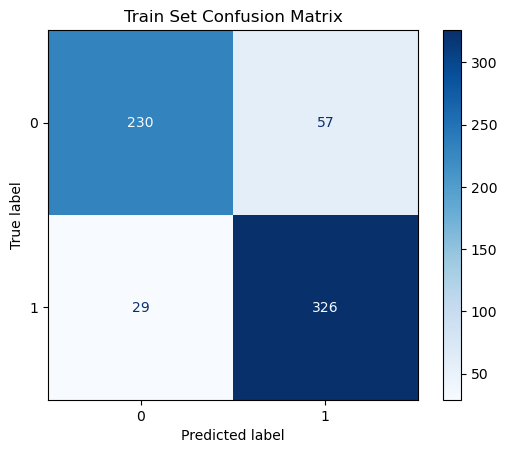

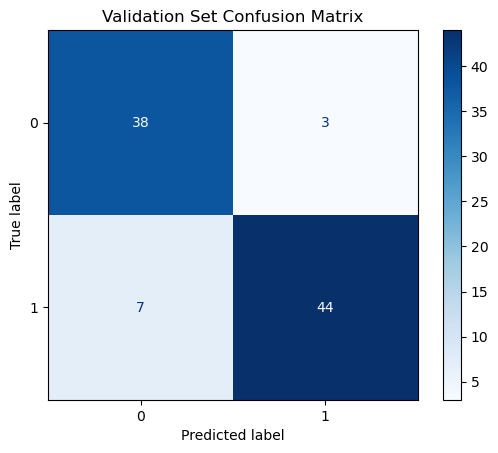

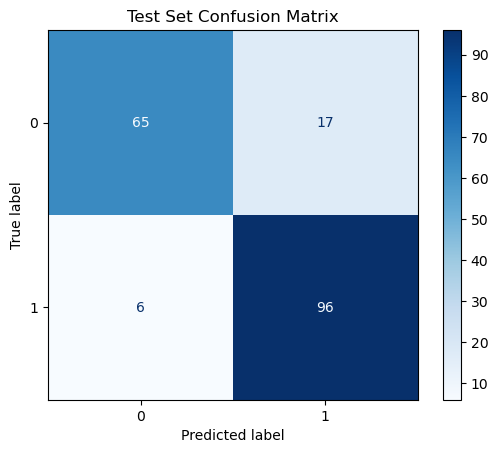

In [185]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning for KNN
best_k = 0
best_accuracy = 0
best_metric = ''
k_values = [3, 5, 7, 11, 15,17,20]
distance_metrics = ['euclidean', 'manhattan']
best_model=None

for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)
        val_pred = knn.predict(X_val)
        acc = accuracy_score(y_val, val_pred)

        if acc > best_accuracy:
            best_k = k
            best_accuracy = acc
            best_metric = metric
            best_model = knn

print(f"Best k: {best_k}, Best metric: {best_metric}, Validation accuracy: {best_accuracy:.4f}")

# Evaluate on the test set with the best parameters


y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)
y_train_pred = best_model.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))
for cm in ((cm_train,"Train") , (cm_val,"Validation") , (cm_test,"Test")):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[0])
    disp.plot(cmap='Blues')
    plt.title(f"{cm[1]} Set Confusion Matrix")
    plt.show()


## 2. Logistic Regression

C = 0.001, Validation Accuracy = 0.55
C = 0.01, Validation Accuracy = 0.84
C = 0.1, Validation Accuracy = 0.90
C = 1, Validation Accuracy = 0.89
C = 10, Validation Accuracy = 0.86
C = 100, Validation Accuracy = 0.86

Best C: 0.1 with Validation Accuracy: 0.902
Convolution Matrix of the training set with best parameter C: 0.1.


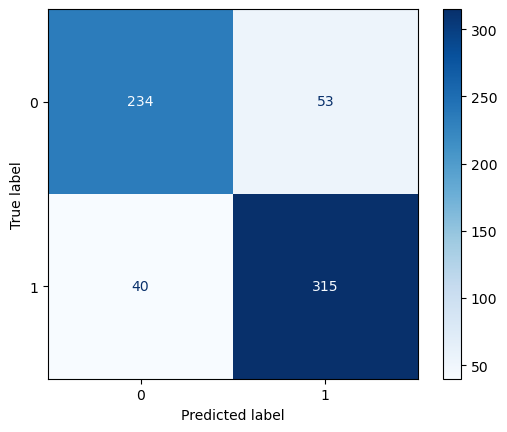

Convolution Matrix of the validation set with best parameter C: 0.1.


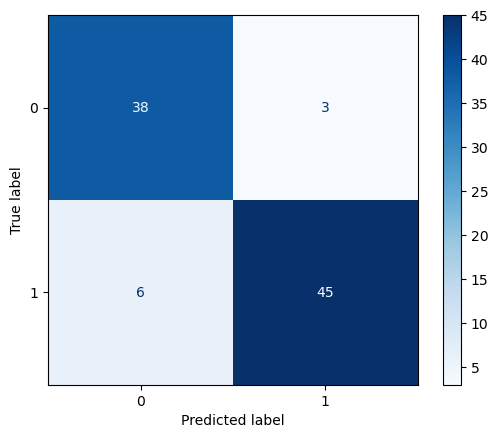


Test Accuracy with Best C (0.1): 0.89
Convolution Matrix of the testing set with best parameter C: 0.1.


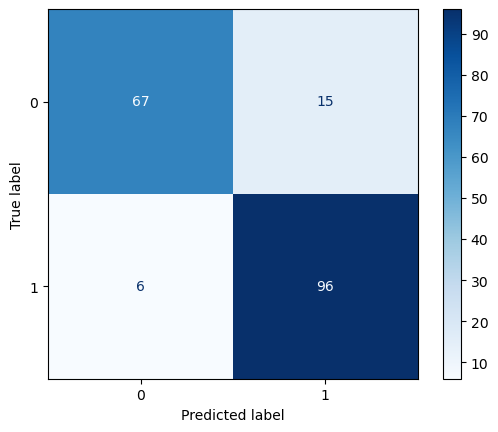

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# # Step 1: Train a logistic regression model with default parameters
# log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence
# log_reg.fit(X_train, y_train)
# 
# # Step 2: Evaluate on the validation set
# y_val_pred = log_reg.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy (Default Parameters): {val_accuracy:.2f}")

# Tune the regularization parameter C using the validation set
best_C = None
best_accuracy = 0

# Try different values of C
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
for C in C_values:
    # Train the model with the current C value
    log_reg = LogisticRegression(C=C, max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_val_pred = log_reg.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"C = {C}, Validation Accuracy = {val_accuracy:.2f}")
    
    # Track the best C value
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_C = C
        
        
print(f"\nBest C: {best_C} with Validation Accuracy: {best_accuracy:.3f}")


#Train the final model with the best C value on the full training set
final_log_reg = LogisticRegression(C=best_C, max_iter=1000)
final_log_reg.fit(X_train, y_train)
y_train_pred = final_log_reg.predict(X_train)
print(f"Convolution Matrix of the training set with best parameter C: {best_C}.")
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot(cmap='Blues')
plt.show()

print(f"Convolution Matrix of the validation set with best parameter C: {best_C}.")
y_val_pred = final_log_reg.predict(X_val)
cm_val = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp.plot(cmap='Blues')
plt.show()

#Evaluate on the test set
y_test_pred = final_log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy with Best C ({best_C}): {test_accuracy:.2f}")
print(f"Convolution Matrix of the testing set with best parameter C: {best_C}.")
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap='Blues')
plt.show()

# 3. Feedforward Neural Network

Hidden Layer Size: 16
--> Learning Rate: 0.001
Epoch [20/100], Train Accuracy: 0.5530, Val Accuracy: 0.5543, Train F1: 0.7121, Val F1: 0.7133
Epoch [40/100], Train Accuracy: 0.5530, Val Accuracy: 0.5543, Train F1: 0.7121, Val F1: 0.7133
Epoch [60/100], Train Accuracy: 0.5530, Val Accuracy: 0.5543, Train F1: 0.7121, Val F1: 0.7133
Epoch [80/100], Train Accuracy: 0.5530, Val Accuracy: 0.5543, Train F1: 0.7121, Val F1: 0.7133
Epoch [100/100], Train Accuracy: 0.5530, Val Accuracy: 0.5543, Train F1: 0.7121, Val F1: 0.7133


--> Learning Rate: 0.01
Epoch [20/100], Train Accuracy: 0.6589, Val Accuracy: 0.6957, Train F1: 0.7402, Val F1: 0.7705
Epoch [40/100], Train Accuracy: 0.6791, Val Accuracy: 0.7283, Train F1: 0.7616, Val F1: 0.7967
Epoch [60/100], Train Accuracy: 0.6916, Val Accuracy: 0.7174, Train F1: 0.7735, Val F1: 0.7903
Epoch [80/100], Train Accuracy: 0.7040, Val Accuracy: 0.7174, Train F1: 0.7846, Val F1: 0.7903
Epoch [100/100], Train Accuracy: 0.7025, Val Accuracy: 0.7283, Train F1

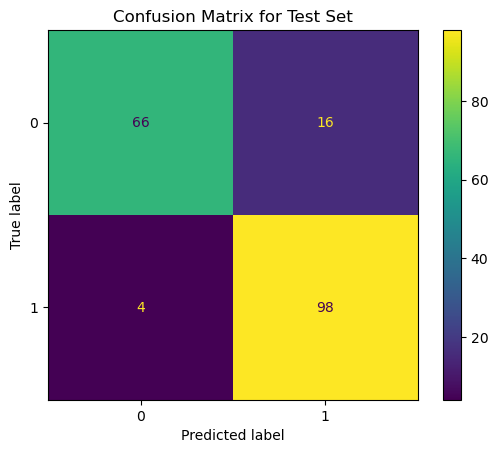

Best Validation Accuracy: 88.0435 %
Best Validation F1 Score: 88.8889 %


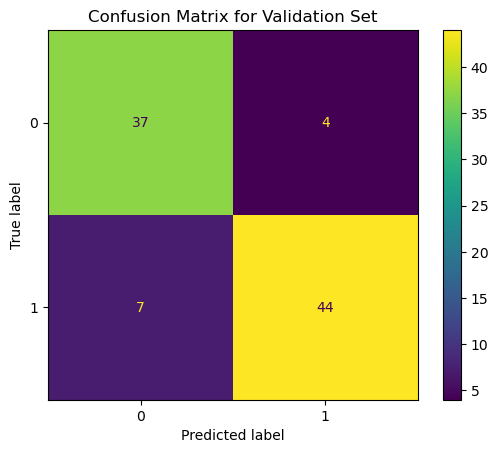

Best Training Accuracy: 84.1121 %
Best Training F1 Score: 86.0656 %


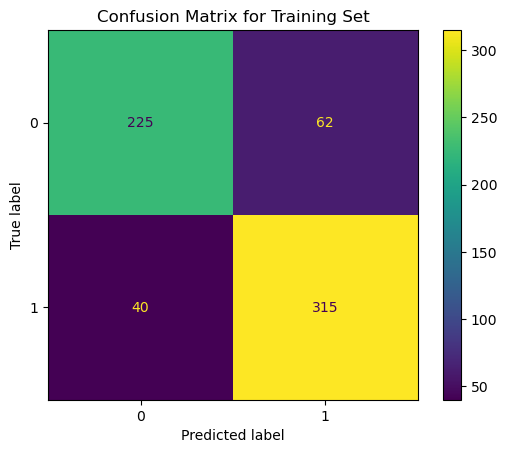

In [191]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class FeedForwardNeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForwardNeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.sigmoid(self.output(x))
        return x

# Hyperparameters
hidden_size = [16, 32]
learning_rate = [0.001, 0.01, 0.1]
num_epochs = 100

# Constants
input_size = X_train.shape[1]
num_classes = 1     # Binary classification

dict_FNN = {}
results_FNN = {}

# Early Stopping Parameters
patience = 5 

for hidden in hidden_size:
    print(f"Hidden Layer Size: {hidden}")
    for lr in learning_rate:
        print(f"--> Learning Rate: {lr}")
        train_accuracy_FNN, val_accuracy_FNN = [], []
        train_f1_score_FNN, val_f1_score_FNN = [], []
        model = FeedForwardNeuralNetwork(input_size, hidden, num_classes)
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_weights = None

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train.values, dtype=torch.float32))
            loss = criterion(outputs.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            
            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32)).squeeze()
                val_loss = criterion(val_outputs, torch.tensor(y_val.values, dtype=torch.float32))
                val_pred = (val_outputs >= 0.5).float()
                val_accuracy = accuracy_score(y_val, val_pred.numpy())
                val_f1 = f1_score(y_val, val_pred.numpy())
                
                # Append metrics
                train_accuracy_FNN.append(train_accuracy)
                train_f1_score_FNN.append(train_f1)
                val_accuracy_FNN.append(val_accuracy)
                val_f1_score_FNN.append(val_f1)
                
                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    best_model_weights = model.state_dict()  # Save the best model weights
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                       
                        print(f"Early stopping at epoch {epoch + 1}")
                        print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")
                        print("\n")
                        break
            train_outputs = model(torch.tensor(X_train.values, dtype=torch.float32)).squeeze()
            train_pred = (train_outputs >= 0.5).float()
            train_accuracy = accuracy_score(y_train, train_pred.numpy())
            train_f1 = f1_score(y_train, train_pred.numpy())
            # Append metrics
            train_accuracy_FNN.append(train_accuracy)
            train_f1_score_FNN.append(train_f1)
            val_accuracy_FNN.append(val_accuracy)
            val_f1_score_FNN.append(val_f1)     
            
            if (epoch + 1) % 20 == 0:
                train_outputs = model(torch.tensor(X_train.values, dtype=torch.float32)).squeeze()
                train_pred = (train_outputs >= 0.5).float()
                train_accuracy = accuracy_score(y_train, train_pred.numpy())
                train_f1 = f1_score(y_train, train_pred.numpy())
                
                train_accuracy_FNN.append(train_accuracy)
                train_f1_score_FNN.append(train_f1)
                    
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")
        print("\n")
        
        dict_FNN[(hidden, lr)] = model
        results_FNN[(hidden, lr)] = {
            "train_accuracy": train_accuracy_FNN,
            "val_accuracy": val_accuracy_FNN,
            "train_f1_score": train_f1_score_FNN,
            "val_f1_score": val_f1_score_FNN
        }
    print("--------------------------------------------------------------------------------------------------------------")
    
    
# Find the best hyperparameters
best_hidden = None
best_lr = None
best_val_accuracy = 0

for (hidden, lr), metrics in results_FNN.items():
    if metrics["val_accuracy"][-1] > best_val_accuracy:
        best_val_accuracy = metrics["val_accuracy"][-1]
        best_hidden = hidden
        best_lr = lr
        
print(f"--> Best Hyperparameters: Hidden Layer Size = {best_hidden}, Learning Rate = {best_lr}")

# Test the final model with the best hyperparameters
best_model = FeedForwardNeuralNetwork(input_size, best_hidden, num_classes)
best_model.load_state_dict(dict_FNN[(best_hidden, best_lr)].state_dict())
best_model.eval()

# Predict the classes of the test set
test_outputs = best_model(torch.tensor(X_test.values, dtype=torch.float32)).squeeze()
test_pred = (test_outputs >= 0.5).float()

# Calculate the accuracy & F1 score for the test set
f1_score_test = f1_score(y_test, test_pred.numpy())
accuracy_test = accuracy_score(y_test, test_pred.numpy())
print(f"Test Accuracy: {accuracy_test * 100:.4f} %")
print(f"Test F1 Score: {f1_score_test * 100:.4f} %")

# Display the confusion matrix for the test set
cm = confusion_matrix(y_test, test_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix for Test Set")
plt.show()




# Display the accuracy, f1 score & confusion matrix for the validation set with the best hyperparameters
print(f"Best Validation Accuracy: {best_val_accuracy * 100:.4f} %")
print(f"Best Validation F1 Score: {results_FNN[(best_hidden, best_lr)]['val_f1_score'][-1] * 100:.4f} %")

val_outputs = best_model(torch.tensor(X_val.values, dtype=torch.float32)).squeeze()
val_pred = (val_outputs >= 0.5).float()
cm_val = confusion_matrix(y_val, val_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix for Validation Set")
plt.show()



# Display the accuracy, f1 score & confusion matrix for the training set with the best hyperparameters
print(f"Best Training Accuracy: {results_FNN[(best_hidden, best_lr)]['train_accuracy'][-1] * 100:.4f} %")
print(f"Best Training F1 Score: {results_FNN[(best_hidden, best_lr)]['train_f1_score'][-1] * 100:.4f} %")

train_outputs = best_model(torch.tensor(X_train.values, dtype=torch.float32)).squeeze()
train_pred = (train_outputs >= 0.5).float()
cm_train = confusion_matrix(y_train, train_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix for Training Set")
plt.show()
        